In [1]:
import os
import torch
from torchtools.utils import plot_batch

from train_autoprotonet import get_dataset, get_model
from vis_prototypes import get_prototypes, get_support_query_data_labels_model, generate_prototype_img_using_adam

In [2]:
ckpt_dir = '/vulcanscratch/psando/checkpoints-meta/workshop_paper_checkpoints/cifarfs-autoprotonet-5w5s'

test_way = 5
val_shot = 5
val_query = 5
val_episode = 2000
episodes_per_batch = 1

class Options(object):
    def __init__(self, dataset, network, test_way, val_shot, val_query, head='ProtoNet'):
        self.dataset = dataset
        self.network = network
        self.head = head
        self.activation = 'LeakyReLU'
        self.test_way = test_way
        self.val_shot = val_shot
        self.val_query = val_query
        self.episodes_per_batch = episodes_per_batch
opt = Options(dataset=('CIFAR_FS' if 'cifarfs' in ckpt_dir else 'miniImageNet'), network=('AutoProtoNet' if 'autoprotonet' in ckpt_dir else 'ProtoNet'), test_way=test_way, val_shot=val_shot, val_query=val_query)

In [3]:
data_support, labels_support, data_query, labels_query, embedding_net, cls_head = get_support_query_data_labels_model(opt)

Loading CIFAR-FS dataset - phase train
Loading CIFAR-FS dataset - phase val


/scratch0/slurm_880741/tmp-aq-env/lib64/python3.6/site-packages/torchvision/transforms/functional.py:114: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()


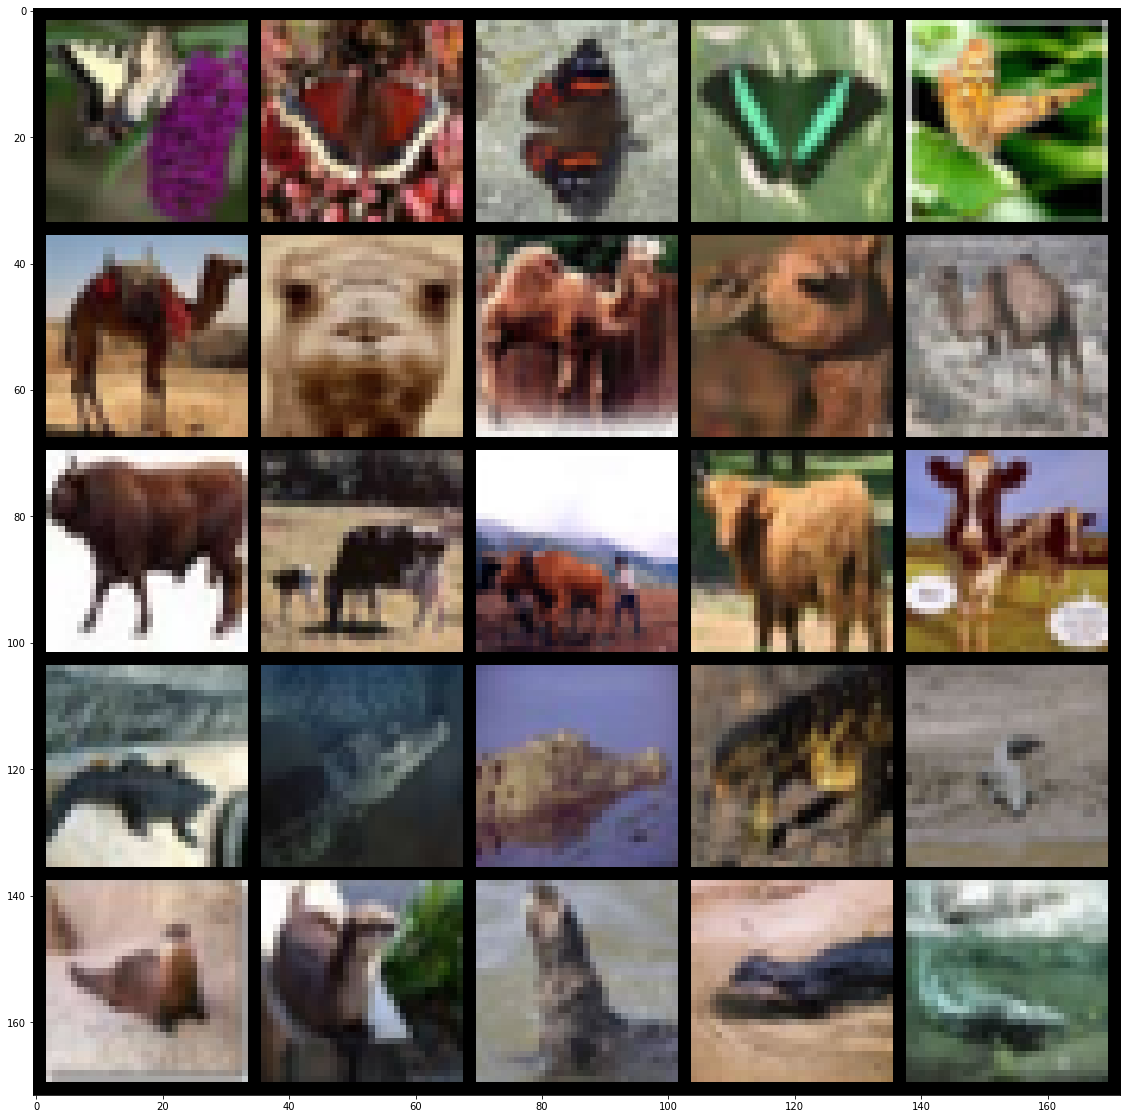

In [4]:
labels_support = labels_support.squeeze()
indices = torch.argsort(labels_support)

plot_batch(data_support[indices].cpu(), figsize=(20,20), nrow=test_way)

In [5]:
ckpt = torch.load(os.path.join(ckpt_dir, 'best_model.pth'))
cls_head.load_state_dict(ckpt['head'], strict=True)
embedding_net.load_state_dict(ckpt['embedding'], strict=True)

<All keys matched successfully>

In [6]:
with torch.no_grad():
    emb_query = embedding_net(data_query)
    emb_support = embedding_net(data_support)
    print('emb query shape', emb_query.shape)
    print('emb support shape', emb_support.shape)
    train_n_support = test_way * val_shot
    train_n_query = test_way * val_query
    emb_query = emb_query.reshape(episodes_per_batch, train_n_query, -1)
    emb_support = emb_support.reshape(episodes_per_batch, train_n_support, -1)
    print('emb query shape reshaped', emb_query.shape)
    print('emb support shape reshaped', emb_support.shape)
    prototypes = get_prototypes(emb_query, emb_support, labels_support, test_way, val_shot)
    print('prototypes shape', prototypes.shape)

emb query shape torch.Size([25, 256])
emb support shape torch.Size([25, 256])
emb query shape reshaped torch.Size([1, 25, 256])
emb support shape reshaped torch.Size([1, 25, 256])
prototypes shape torch.Size([1, 5, 256])


/scratch0/slurm_880741/tmp-aq-env/lib64/python3.6/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [19]:
proto_imgs_adam = generate_prototype_img_using_adam(embedding_net, prototypes.squeeze(dim=0), img_size=(32 if opt.dataset == 'CIFAR_FS' else 84), 
                                                    lr=0.01,
                                                    max_steps=20000,
                                                    use_tv=True)

[Step 0] Last LR: 0.01 L2 norm: 40.845027923583984
[Step 500] Last LR: 0.01 L2 norm: 8.72665023803711
[Step 1000] Last LR: 0.01 L2 norm: 7.89259147644043
[Step 1500] Last LR: 0.01 L2 norm: 8.158166885375977
[Step 2000] Last LR: 0.01 L2 norm: 7.608532905578613
[Step 2500] Last LR: 0.01 L2 norm: 8.524548530578613
[Step 3000] Last LR: 0.01 L2 norm: 8.118691444396973
[Step 3500] Last LR: 0.01 L2 norm: 8.250324249267578
[Step 4000] Last LR: 0.01 L2 norm: 8.153970718383789
[Step 4500] Last LR: 0.01 L2 norm: 8.436677932739258
[Step 5000] Last LR: 0.01 L2 norm: 8.292253494262695
[Step 5500] Last LR: 0.01 L2 norm: 8.565109252929688
[Step 6000] Last LR: 0.01 L2 norm: 8.917558670043945
[Step 6500] Last LR: 0.01 L2 norm: 8.552587509155273
[Step 7000] Last LR: 0.01 L2 norm: 8.0110445022583
[Step 7500] Last LR: 0.01 L2 norm: 8.340394973754883
[Step 8000] Last LR: 0.01 L2 norm: 8.599002838134766
[Step 8500] Last LR: 0.01 L2 norm: 8.42626667022705
[Step 9000] Last LR: 0.01 L2 norm: 8.19836139678955
[S

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


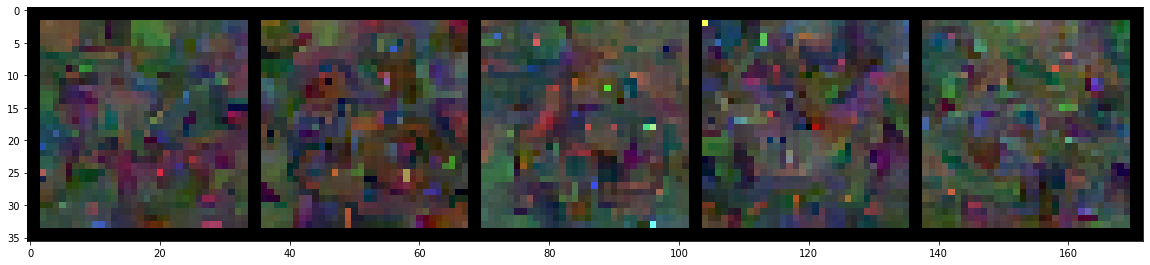

In [20]:
plot_batch(proto_imgs_adam.cpu()*3, figsize=(20,20))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


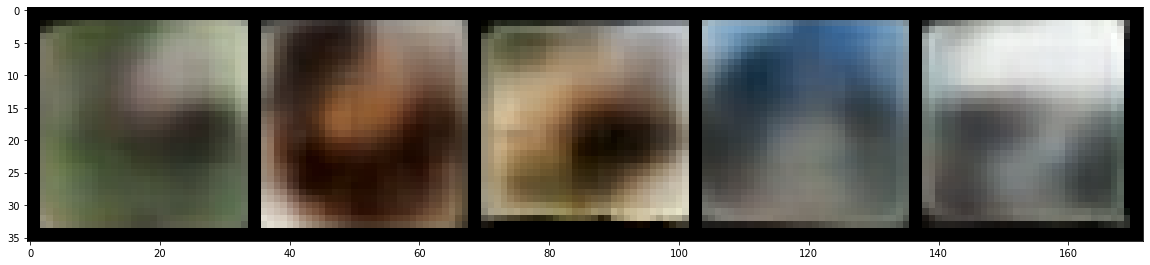

In [21]:
proto_imgs_decoder = embedding_net.forward_plus_decoder(proto_imgs_adam)
plot_batch(proto_imgs_decoder.cpu(), figsize=(20,20))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


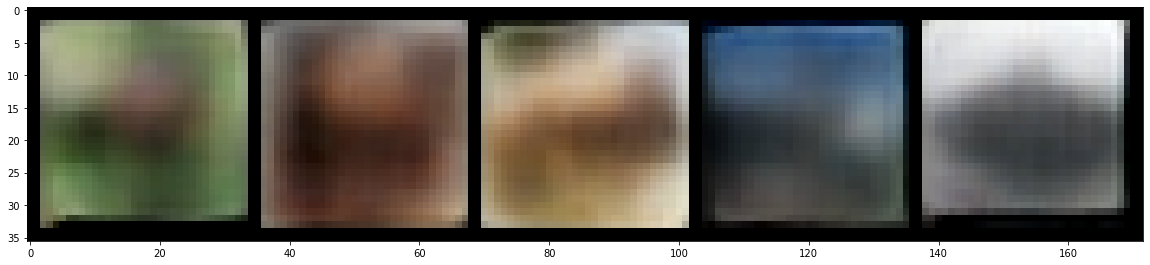

In [16]:
plot_batch(embedding_net.forward_decoder(prototypes.reshape(embedding_net.embedding_shape)).cpu(), figsize=(20,20))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


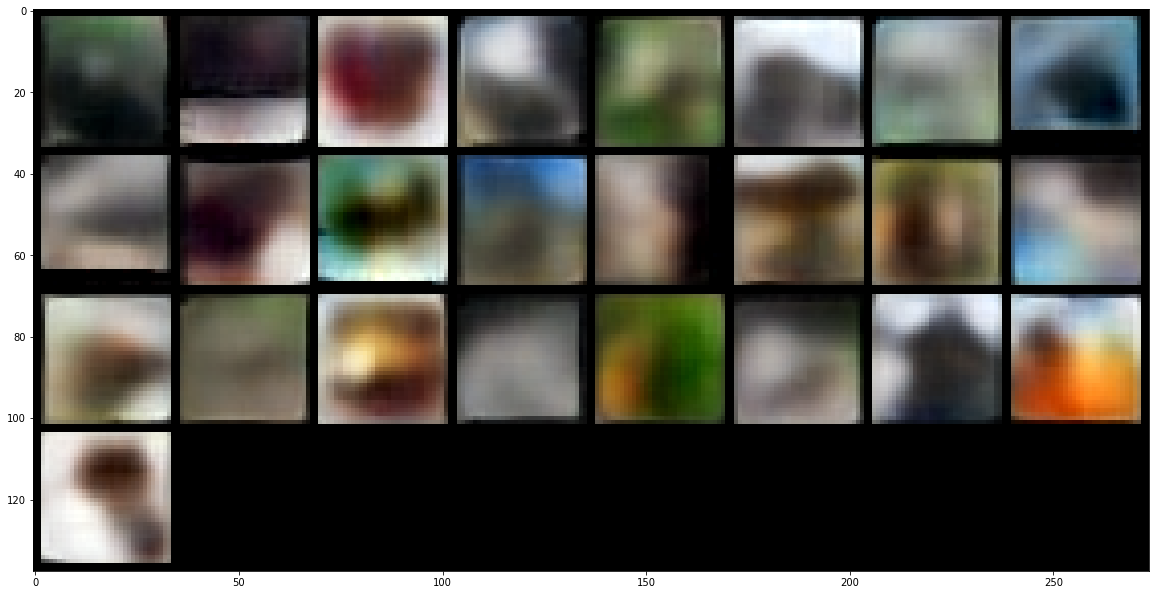

In [17]:
plot_batch(embedding_net.forward_decoder(emb_query.reshape(embedding_net.embedding_shape)).cpu(), figsize=(20,20))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


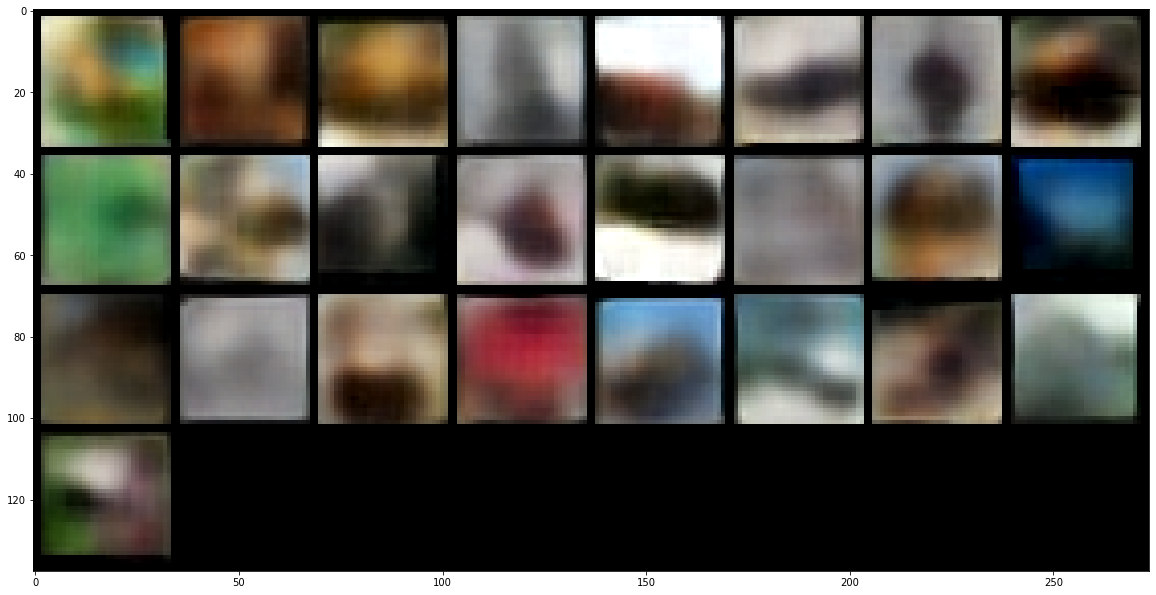

In [18]:
plot_batch(embedding_net.forward_decoder(emb_support.reshape(embedding_net.embedding_shape)).cpu(), figsize=(20,20))